# Basics of BigDFT: first runs and managing different calculations, N2 molecule as example

With this lesson you will have to deal with some of the outputs of BigDFT code, such as to learn how to manipulate basic DFT objects from a python script.
BigDFT can be also run in "traditional" way, i.e. with input and output files. 
We will here employ python commands to show how the I/O files of BigDFT can be handled
by simple scripting techniques. 

First you need to have the correct environment variables: the script "bigdftvars.sh" from the install/bin directory of bigdft has to be sourced ("source bigdftvars.sh") before doing this tutorial and load the module python *BigDFT*. See [this page](http://bigdft.org/Wiki/index.php?title=Prepare_the_environment) for more information.

In [1]:
from BigDFT import Calculators as calc

The main executable of the BigDFT suite is *bigdft*.

## Atomic position file: 'posinp.xyz'

A simple file with the position of atoms is enough to run bigdft performing a single-point calculation (calculating the ground state energy of the system). 
Consider for example the N2 molecule, given by the <a href="http://bigdft.org/images/f/f1/N2_posinp.xyz">posinp.xyz</a> file:
<pre>
2 angstroem
free
N 0. 0. 0.
N 0. 0. 1.11499</pre>
Copy it into the current directory.

In [2]:
study = calc.SystemCalculator() #Create a calculator
study.run() #run the code

Initialize a Calculator with OMP_NUM_THREADS=2 and command /local/binaries/gfortran-fpe-1.8/install/bin/bigdft
Creating the yaml input file "input.yaml"
Executing command:  /local/binaries/gfortran-fpe-1.8/install/bin/bigdft


<BigDFT.Logfiles.Logfile instance at 0x7fdc2c1f60e0>

The `run()` method of the `BigDFT.Calculators.SystemCalculator` class shows in the standard output which is the 
command that is invoked.
Then, an instance of the `Logfile` class is returned.
Such class can be used (we will see after) to extract the information about the electronic structure of the system.

In the disk, after that the run is performed, different files are created:
* [input_minimal.yaml](./input_minimal) which contains the minimal set of input variables to perform the run;
* [log.yaml](./log.yaml) which contains the log of the run with all calculated quantities;
* [time.yaml](./time.yaml) and [forces_posinp.xyz](./forces_posinp.xyz) which we will see later.

For its I/O, `bigdft` uses the [yaml](http://www.yaml.org/spec) format. 
If you look at the [input_minimal.yaml](./input_minimal) file, you can see:
<pre>
  #---------------------------------------------------------------------- Minimal input file
  #This file indicates the minimal set of input variables which has to be given to perform 
  #the run. The code would produce the same output if this file is used as input.
 posinp:
   units: angstroem
   positions:
   - N: [0.0, 0.0, 0.0]
   - N: [0.0, 0.0, 1.114989995956421]
   properties:
     format: xyz
     source: posinp.xyz</pre>

In this case, only the atomic positions are indicated using a yaml format.

In the log file [log.yaml](./log.yaml), BigDFT automatically displays all the input parameters used for the calculations. 

The parameters which were not explicitly given are set to a default value, except the atomic positions of course, which have to be given. As we did not specified input files here, our run is a single-point LDA calculation, without spin-polarisation.

## Using a naming scheme for Input/Output files

To specify non-default input parameters to the code, we should create a yaml file with a naming prefix. By default, this prefix is *input* (or *posinp.xyz* for atomic input positions). One can choose the naming prefix by providing an argument to bigdft command line.

However, there is a one-to-one correspondence between a yaml file and a python dictionary. For this reason
we will create the input parameters of this runs from dictionaries. See the useful [yaml online parser](http://yaml-online-parser.appspot.com/) page to understand the correspondence.

Imagine for example that you are interested in visualizing the wavefunctions output of the calculation. To do that, you should enter the suitable parameters in the .yaml file. 
Create a new calculation set by using, for instance, the `LDA` prefix.
Instead of creating a yaml input file *LDA.yaml* by hand, we create a dictionary which will be serialized into yaml by our *SystemCalculator* class.

In [3]:
inp = {}
inp['dft'] = { 'ixc': 'LDA' }
inp['output'] = { 'orbitals': 'binary' } #this is the parameter that output the orbitals on the disk

This shows the one-to-one correspondence between the keys of the input file and the ones of the python dictionary.
However, it might be uneasy, especially for beginners, to understand what is the function of each `key -> value`
mapping, and even more importantly, to figure out how to adjust basic parameters like the grid spacing, the XC approximation and so on.

In order to simplify the procedure, we have prepared the `BigDFT.InputAction` module, which is a collection of functions acting python dictionary equipped with basic methods and actions. For exemple, the above operations might be implmemented by calling methods of this module:

In [6]:
from BigDFT import InputActions as A
inp={}
A.set_xc(inp,'LDA')
A.write_orbitals_on_disk(inp)

The wavefunctions will be present at the end of calculation, by indicating the value of the key *orbitals* in the output dictionary.

In [7]:
#Run the code with the LDA prefix, using a python dictionary (dico) and the file 'posinp.xyz' for the atomic positions.
lda = study.run(name="LDA",input=inp,posinp='posinp.xyz')

Creating the yaml input file "./LDA.yaml"
Executing command:  /local/binaries/gfortran-fpe-1.8/install/bin/bigdft -n LDA


Now we can retrieve important informations on the run. See the examples below:

In [8]:
lda.energy #this value is in Ha

-19.883483725688038

In [9]:
lda.evals[0].tolist() # the eigenvalues in Ha ([0] stands for the first K-point, here meaningless)

[[-1.031892602676,
  -0.4970106443181,
  -0.4307276296665,
  -0.430727289646,
  -0.3812107719151]]

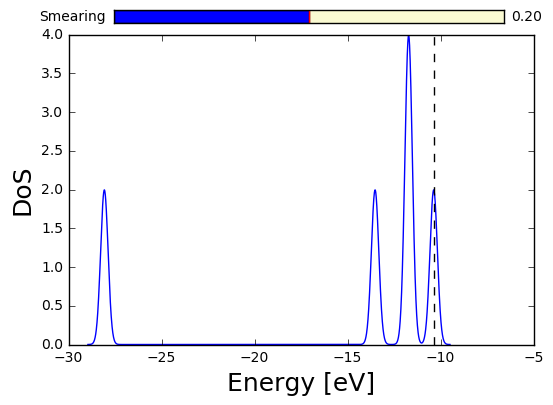

In [10]:
lda.get_dos().plot() #the density of states

When using a naming scheme, the output files are placed in a directory called  **data-LDA**. In our LDA example, the wavefunctions of the system can thus be found in the **data-LDA** directory:

In [11]:
!ls data-LDA

time-LDA.yaml			  wavefunction-k001-NR.bin.b000004
wavefunction-k001-NR.bin.b000001  wavefunction-k001-NR.bin.b000005
wavefunction-k001-NR.bin.b000002  wavefunction-rhoij.bin
wavefunction-k001-NR.bin.b000003


Here 001 means the first K-point (meaningless in this case), N stands for non spin-polarized, R for real part and the remaining number is the orbital ID. Post-processing of these files is done in the another tutorial.

In the same spirit, another calculation can be done with different parameters. Imagine we want to perform a Hartree-Fock calculation. In BigDFT, this can be done by putting the `ixc` input variable to `HF`. So, we use the same dictionary changing only the *dft* key.
We add also a *posinp* key to indicate what atomic positions file we use (this was done when we indicate posinp='posinp.xyz' into the *run* method).

In [12]:
A.set_xc(inp,'HF')
A.set_atomic_positions(inp,'posinp.xyz')
hf = study.run(name="HF",input=inp) #Run the code with the name scheme HF

Creating the yaml input file "./HF.yaml"
Executing command:  /local/binaries/gfortran-fpe-1.8/install/bin/bigdft -n HF
ERROR: some problem occured during the execution of the command, check the 'debug/' directory and the logfile
The error occured is BIGDFT_INPUT_FILE_ERROR
Additional Info:  The pseudopotential parameter file "psppar.N" is lacking, and no registered pseudo found for "N"


This time, an error will occur, as we can see above. The same error is specified at the end of the file [log-HF.yaml](./log-HF.yaml)
and also in [debug/bigdft-err-0.yaml](./debug/bigdft-err-0.yaml):
<pre>
 Additional Info:
   The pseudopotential parameter file "psppar.N" is lacking, and no registered pseudo found 
   for "N"</pre>

This is because the pseudopotential is assigned by default in the code only for LDA and PBE XC approximations. You can find <a href="http://bigdft.org/images/f/f5/Psppar.N">here</a> the pseudopotential which is taken by default in the LDA run. Put it in a psppar.N file, and run the calculation.
Another alternative is to specify the internal PSP that might be used, taking from the default database of BigDFT. This can be done as follows:

In [13]:
inp['psppar.N']={'Pseudopotential XC': 1} #here 1 stands for LDA as per the XC codes
hf = study.run(name="HF",input=inp) #Run the code with the name scheme HF

Creating the yaml input file "./HF.yaml"
Executing command:  /local/binaries/gfortran-fpe-1.8/install/bin/bigdft -n HF


When possible, care should be taken in choosing a pseudopotential which has been generated with the same XC approximation used. Unfortunately, at present HGH data are only available for semilocal functionals. For example, the same exercise as follows could have been done with Hybrid XC functionals, like for example PBE0 (ixc=-406). See the <a href="http://bigdft.org/Wiki/index.php?title=XC_codes">XC codes</a> for a list of the supported XC functionals. Data of the calculations can be analysed.

In [14]:
A.set_xc(inp,'PBE0')
pbe0 = study.run(name="PBE0",input=inp) #Run the code with the name scheme PBE0

Creating the yaml input file "./PBE0.yaml"
Executing command:  /local/binaries/gfortran-fpe-1.8/install/bin/bigdft -n PBE0


The variables *lda*, *hf*, and *pbe0* contains all information about the calculation. This is a class Logfile which simplify considerably the extraction of parameters of the associated output file *log-LDA.yaml*. If we simply type:

In [15]:
from futile.Utils import write
write(lda)

- Atom types:
  - N
- Cell: Free BC
- Convergence criterion on forces: 0.0
- Max val of Forces: 0.05670554140672
- Energy: -19.883483725688038
- Symmetry group: disabled
- fermi_level: -0.3812107719151
- Number of Atoms: 2
- Convergence criterion on Wfn. Residue: 0.0001
- No. of KS orbitals:
  - 5



we display some information about the LDA calculation. For instance, we can extract the eigenvalues of the Hamiltonian *i.e.* the DOS (Density of States):

In [16]:
lda.evals[0].tolist()

[[-1.031892602676,
  -0.4970106443181,
  -0.4307276296665,
  -0.430727289646,
  -0.3812107719151]]

*lda.log* is the python dictionary associated to the full output file. 
The [tutorial](./Logfiles-Basic.ipynb) explains the basic methods. The following exercise (and its [solution](./Tutorial-N2-solution.ipynb)) gives some clues about it.

In [17]:
write(pbe0)

- Atom types:
  - N
- Cell: Free BC
- Convergence criterion on forces: 0.0
- Max val of Forces: 0.1001956813857
- Energy: -19.968681994148028
- Symmetry group: disabled
- fermi_level: -0.4502961029675
- Number of Atoms: 2
- Convergence criterion on Wfn. Residue: 0.0001
- No. of KS orbitals:
  - 5




<h2>Exercise</h2>

Compare the values of the HOMO and HOMO-1 eigenvalues for the LDA and the HF run.
Change the values of the hgrid and crmult to find the converged values.
Note that, both in the LDA and in the HF calculation, a norm-conserving PSP is used.
The results can be compared to all-electron calculations, done with different basis sets, from references (units are eV) 
(1) S.&nbsp;Hamel <i>et&nbsp;al.</i> J. Electron Spectrospcopy and Related Phenomena 123 (2002) 345-363 and (2) P.&nbsp;Politzer, F.&nbsp;Abu-Awwad, Theor. Chem. Acc. (1998), 99, 83-87:

<table>
  <tr> <td></td>                      <td>LDA(1)</td>  <td>HF(1)</td>   <td>HF(2)</td>   <td>(Exp.)</td></tr>
  <tr> <td>3&sigma;<sub>g</sub></td>  <td>10.36</td>   <td>17.25</td>   <td>17.31</td>   <td>(15.60)</td></tr>
 <tr> <td>1&pi;<sub>u</sub></td>      <td>11.84</td>   <td>16.71</td>   <td>17.02</td>   <td>(16.98)</td></tr>
 <tr> <td>2&sigma;<sub>u</sub></td>   <td>13.41</td>   <td>21.25</td>   <td>21.08</td>   <td>(18.78)</td></tr>
</table>
 
The results depends, of course, on the precision chosen for the calculation, and of the presence of the pseudopotential.
As it is well-known, the pseudopotential appoximation is however much less severe than the approximation induced by typical XC functionals. We might see that, even in the HF case, the presence of a LDA-based pseudopotential (of rather good quality) does not alter so much the results. Here you can find the values from BigDFT calculation using a very good precision (*hgrid=0.3*, *crmult=7.0*). 
Note that 1 ha=27.21138386 eV.
 
<table>
  <tr> <td></td>                        <td>LDA</td>    <td>HF</td></tr>
  <tr> <td> 3&sigma;<sub>g</sub></td>   <td>10.40</td>  <td>17.32</td></tr>
  <tr> <td> 1&pi;<sub>u</sub></td>      <td>11.75</td>  <td>16.62</td></tr>
  <tr> <td> 2&sigma;<sub>u</sub></td>   <td>13.52</td>  <td>21.30</td></tr>
</table>

How much do these values differ from the calculation with default parameters? Do they converge to a given value?
What is the *correlation* for the N2 molecule in (PSP) LDA?

See here the [solution](./Tutorial-N2-solution.ipynb).